In [ ]:
BATCH_SIZE = 64
N_CHANNELS = 5

In [2]:
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch
from network_definitions.u_net import UNet
from network_definitions.fcn import FCN32s as FCN
from network_definitions.simple_network import SimpleNet
from network_definitions.pyramid_network import PyramidNet
from torchvision.models.segmentation import fcn_resnet101 as FCN_Res101

# Dataset Import

In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

class EnsembleDataset(Dataset):
    """Ensemble dataset."""

    def __init__(self, results_file, transform=None):
        """
        Args:
            results_file (string): File with all the results.
        """
        with open(results_file, 'rb') as f:
            #compressed_file = bz2.BZ2File(f, 'r')
            self.results = pickle.load(f)
        self.transform = transform

    def __len__(self):
        return len(self.results)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data = self.results[idx]
        sample = {'name': data[0], 'valid': data[1], 'im_seg': data[2], 'im_res': data[3]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
from skimage.transform import resize
from torchvision import transforms, utils

class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self,sample):
        name,valid,im_seg,im_res = sample["name"],sample["valid"],sample["im_seg"],sample["im_res"]
        
        return {"name": name, "valid": valid, "im_seg": resize(im_seg,(self.size,self.size,N_CHANNELS),preserve_range=True), "im_res": resize(im_res,(self.size,self.size,1),preserve_range=True)}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        name,valid,im_seg,im_res = sample["name"],sample["valid"],sample["im_seg"],sample["im_res"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        im_seg = im_seg.transpose((2, 0, 1))
        im_res = im_res.transpose((2, 0, 1))
        return {"name": name, 
                "valid": valid,
                "im_seg": torch.from_numpy(im_seg),
                "im_res": torch.from_numpy(im_res)}

In [5]:
trainset = EnsembleDataset(results_file='work_dirs/dataset_generation/dataset_no_img.pkl', 
                           transform=transforms.Compose([Resize(572),
                                                         ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=6)

"""trainset = EnsembleDataset(image_dir='data/coco/test2017',
                           results_file='',
                           transform=transforms.Compose([Rescale(256),
                                                         RandomCrop(224),
                                                         ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)"""



"trainset = EnsembleDataset(image_dir='data/coco/test2017',\n                           results_file='',\n                           transform=transforms.Compose([Rescale(256),\n                                                         RandomCrop(224),\n                                                         ToTensor()]))\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,\n                                          shuffle=True, num_workers=2)"

# Training

In [34]:
from torch.utils.tensorboard import SummaryWriter

#PATH = "work_dirs/simplenet_1/"


def train(net, trainloader, criterion, optimizer, save_path, tensorboard_path, checkpoint=None):
    
    EPOCH = 0
    
    writer = SummaryWriter(log_dir=tensorboard_path)
    
    if checkpoint != None:
        checkpoint = torch.load(checkpoint)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        EPOCH = checkpoint['epoch']
        loss = checkpoint['loss']
        net.train()
    
    for epoch in range(EPOCH,25):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            im_seg = data["im_seg"].to(device, dtype=torch.float)
            im_res = data["im_res"].to(device, dtype=torch.float)
            valid = data["valid"].to(device, dtype=torch.long)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            out_segm,out_class = net(im_seg.float())
            loss_segm = criterion[0](out_segm, im_res.float())
            #loss_class = criterion[1](torch.round(out_class.cpu().detach()).type(torch.LongTensor), valid.cpu().detach())
            loss_class = 0
            loss = loss_segm+loss_class
            loss.backward()
            optimizer.step()

            # print statistics
            #running_loss_segm += loss_segm.item()
            #running_loss_segm += loss_class.item()
            running_loss += loss.item()
            if i % 50 == 49:    # print every 2000 mini-batches
                """print('[%d, %5d] segm loss: %.6f  class loss: %.6f  loss: %.6f' %
                      (epoch + 1, i + 1, running_loss_segm / 50, running_loss_class / 50, running_loss / 50))"""
                print('[%d, %5d] loss: %.6f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
                inp = im_seg.cpu().detach()
                output = out_segm.cpu().detach()
                output_rounded = torch.round(output)
                gt_output = im_res.cpu().detach()
                out_class = out_class.cpu().detach()
                
                inp = inp.numpy()[0].transpose((1,2,0))
                #.squeeze(axis=0)
                output = output.numpy()[0].transpose((1,2,0)).squeeze(axis=2)
                output_rounded = output_rounded.numpy()[0].transpose((1,2,0)).squeeze(axis=2)
                gt_output = gt_output.numpy()[0].transpose((1,2,0)).squeeze(axis=2)
                
                fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(15,15))
                ax=ax.flat
                
                for i in range(0,5):
                    #ax.append(fig.add_subplot(2, 4, i+1))
                    ax[i].set_title("Input "+str(i+1))  # set title
                    ax[i].imshow(inp[:,:,i],cmap='gray',vmin=0,vmax=1)
                    
                
                    
                #ax.append(fig.add_subplot(2, 4, 6))
                ax[5].set_title("Output")  # set title
                ax[5].imshow(output,cmap='gray',vmin=0,vmax=1)
                
                ax[6].set_title("Rounded Output")  # set title
                ax[6].imshow(output_rounded,cmap='gray',vmin=0,vmax=1)
                
                #ax.append(fig.add_subplot(2, 4, 7))
                ax[7].set_title("GT Output")  # set title
                ax[7].imshow(gt_output,cmap='gray',vmin=0,vmax=1)
                
                fig.tight_layout()

                plt.show()
                
                print("Class Evaluation: ", out_class[0])
                print("Max Value: ",output.max()," Min Value: ",output.min())
            
        writer.add_scalar('Loss', loss, epoch)

        if epoch % 5 == 4:        
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, save_path+"epoch_"+str(epoch+1)+".pt")
    
    writer.close()

    print('Finished Training')

In [35]:
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNet(5,[1],activation="sigmoid").float().to(device)

summary(model, (1,5,572,572))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNet                                --                        --
├─Sequential: 1-1                        [1, 1, 572, 572]          --
│    └─Conv2D: 2-1                       [1, 1, 572, 572]          --
│    │    └─Conv2d: 3-1                  [1, 1, 572, 572]          6
│    └─BatchNorm: 2-2                    [1, 1, 572, 572]          --
│    │    └─BatchNorm2d: 3-2             [1, 1, 572, 572]          2
│    └─Sigmoid: 2-3                      [1, 1, 572, 572]          --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Conv2d: 2-4                       [1, 1, 286, 286]          2
│    └─Conv2d: 2-5                       [1, 1, 143, 143]          2
│    └─Conv2d: 2-6                       [1, 1, 72, 72]            2
│    └─Flatten: 2-7                      [1, 5184]                 --
│    └─Linear: 2-8                       [1, 1024]                 5,309,440
│    └─LeakyR

Starting training on network  [1]
[1,     2] loss: 0.023916


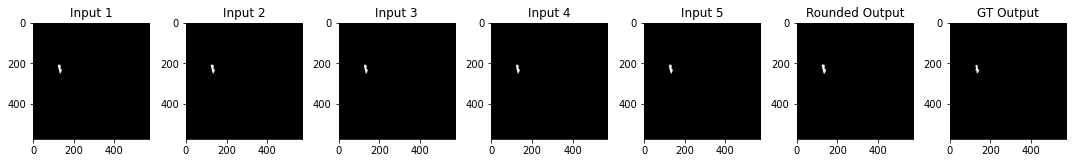

Class Evaluation:  tensor([0.5104])
Max Value:  0.9995332  Min Value:  0.119740754
[1,     4] loss: 0.023913


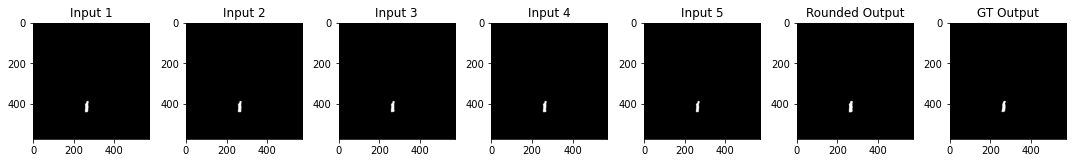

Class Evaluation:  tensor([0.5101])
Max Value:  0.9973882  Min Value:  0.11449248
[1,     6] loss: 0.023053


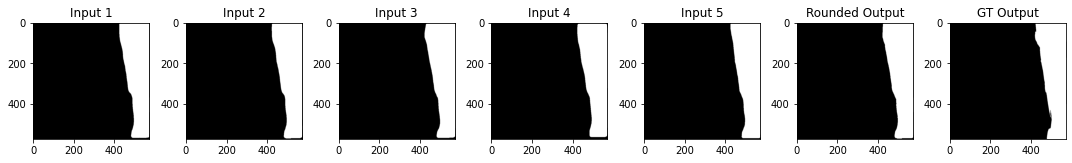

Class Evaluation:  tensor([0.5065])
Max Value:  0.99870217  Min Value:  0.100020595
[1,     8] loss: 0.023493


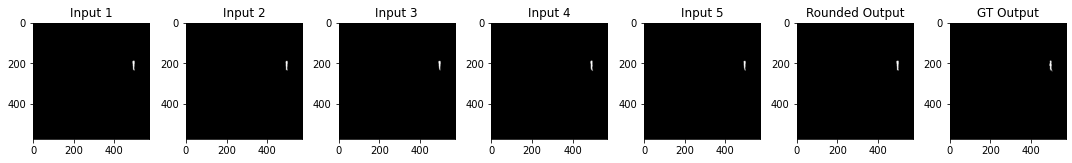

Class Evaluation:  tensor([0.5101])
Max Value:  0.99888796  Min Value:  0.10061776
[1,    10] loss: 0.023065


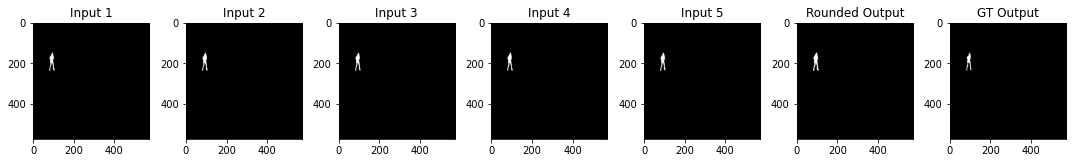

Class Evaluation:  tensor([0.5102])
Max Value:  0.9982048  Min Value:  0.12440432
[1,    12] loss: 0.022005


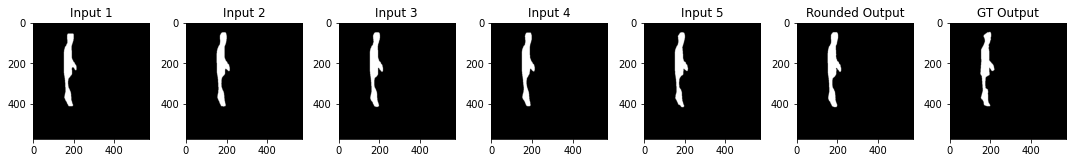

Class Evaluation:  tensor([0.5096])
Max Value:  0.99664587  Min Value:  0.13206927
[1,    14] loss: 0.023103


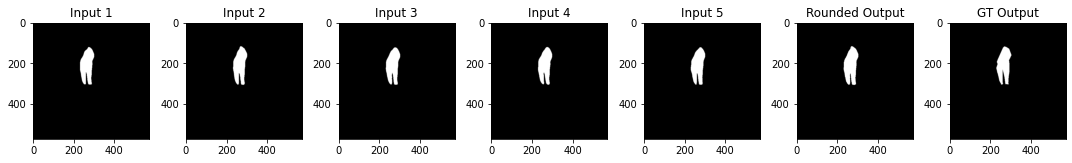

Class Evaluation:  tensor([0.5096])
Max Value:  0.9984085  Min Value:  0.1543269
[1,    16] loss: 0.023888


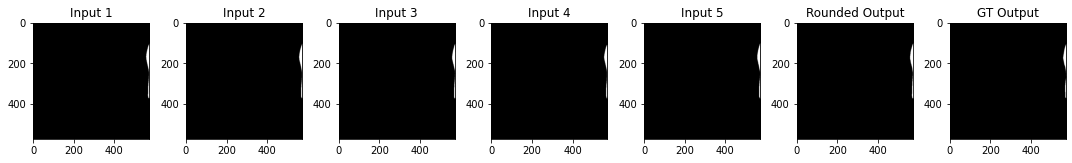

Class Evaluation:  tensor([0.5098])
Max Value:  0.9992507  Min Value:  0.34097257
[1,    18] loss: 0.022621


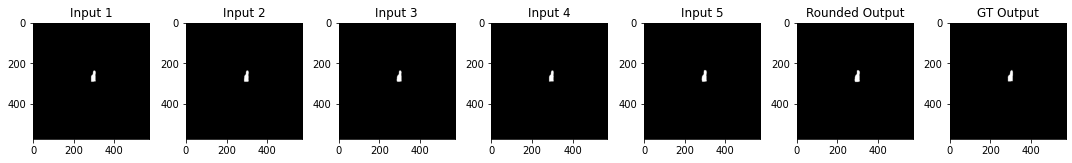

Class Evaluation:  tensor([0.5103])
Max Value:  0.9909734  Min Value:  0.21788964
[1,    20] loss: 0.023715


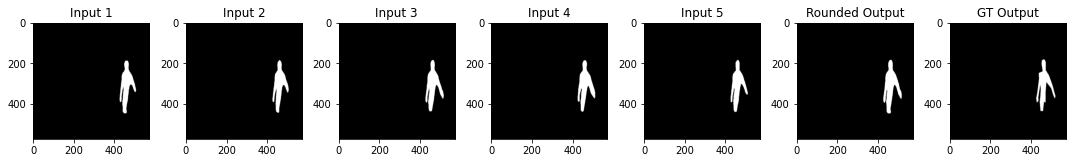

Class Evaluation:  tensor([0.5128])
Max Value:  0.9966889  Min Value:  0.14392045
[1,    22] loss: 0.022738


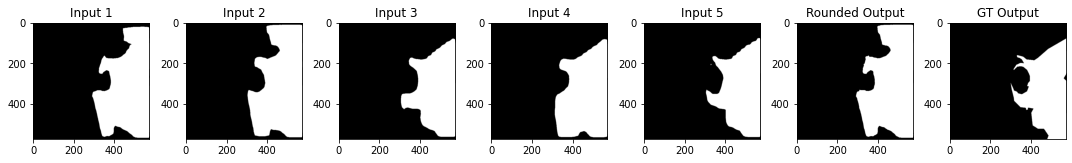

Class Evaluation:  tensor([0.5026])
Max Value:  0.99599624  Min Value:  0.14811647
[1,    24] loss: 0.022755


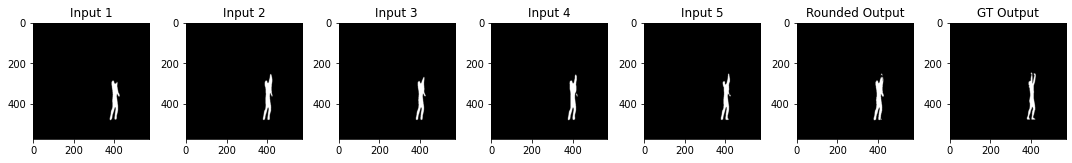

Class Evaluation:  tensor([0.5102])
Max Value:  0.99711454  Min Value:  0.14219633
[1,    26] loss: 0.023367


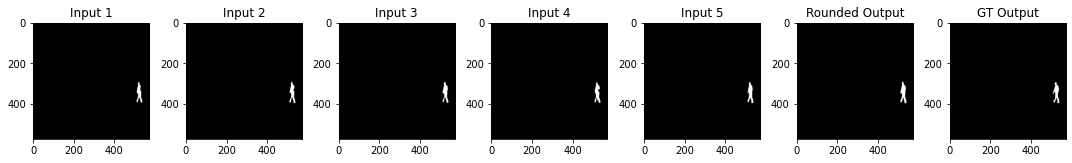

Class Evaluation:  tensor([0.5098])
Max Value:  0.9980096  Min Value:  0.13653874
[1,    28] loss: 0.023828


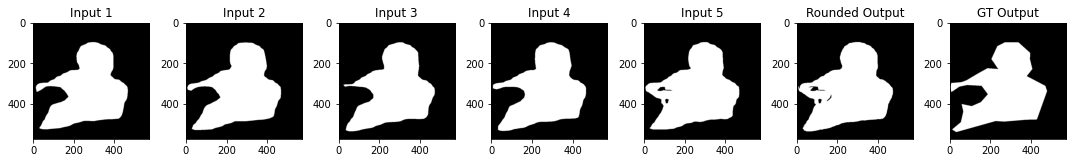

Class Evaluation:  tensor([0.5121])
Max Value:  0.9979261  Min Value:  0.13977882
[1,    30] loss: 0.021663


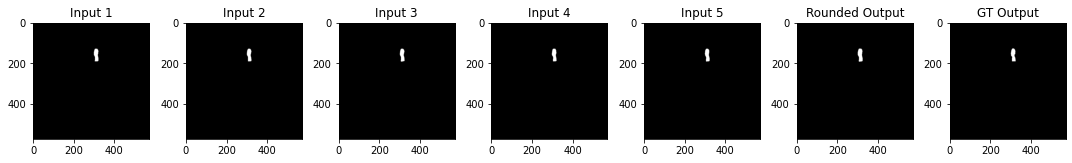

Class Evaluation:  tensor([0.5108])
Max Value:  0.99686337  Min Value:  0.14501357
[1,    32] loss: 0.021905


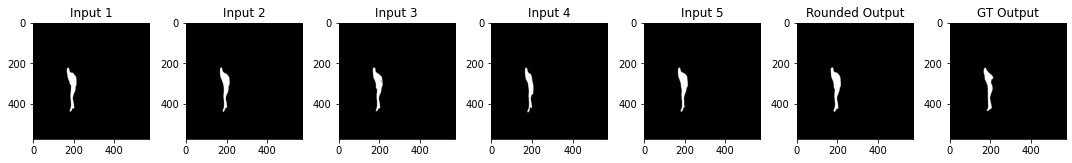

Class Evaluation:  tensor([0.5110])
Max Value:  0.9977132  Min Value:  0.14769824
[1,    34] loss: 0.023504


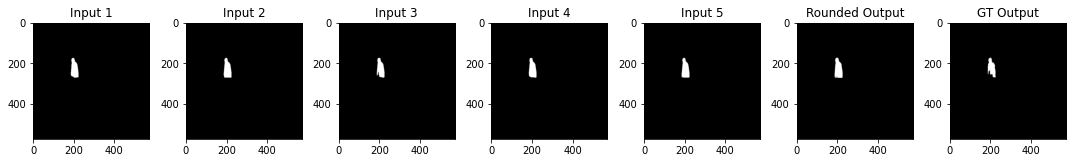

Class Evaluation:  tensor([0.5102])
Max Value:  0.999775  Min Value:  0.15662985
[1,    36] loss: 0.023264


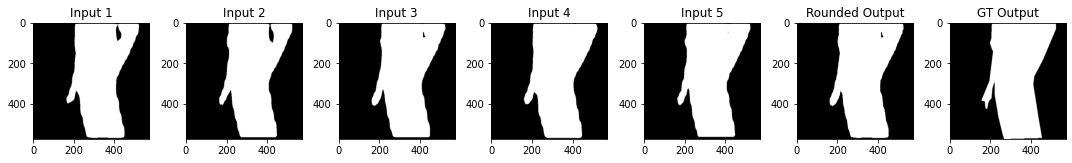

Class Evaluation:  tensor([0.5107])
Max Value:  0.99338514  Min Value:  0.17791928
[1,    38] loss: 0.023422


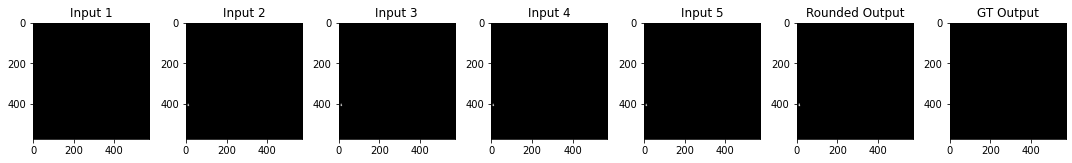

Class Evaluation:  tensor([0.5104])
Max Value:  0.93963736  Min Value:  0.44134855
[1,    40] loss: 0.023447


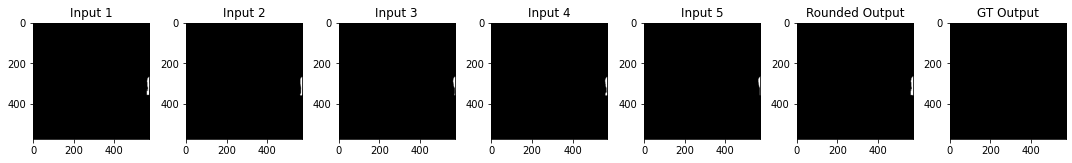

Class Evaluation:  tensor([0.5102])
Max Value:  0.9991084  Min Value:  0.34548062
[1,    42] loss: 0.023178


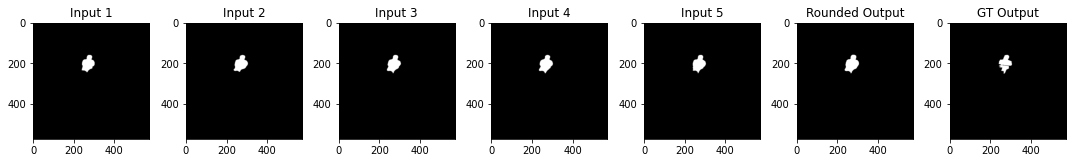

Class Evaluation:  tensor([0.5102])
Max Value:  0.9986852  Min Value:  0.1364817
[1,    44] loss: 0.022691


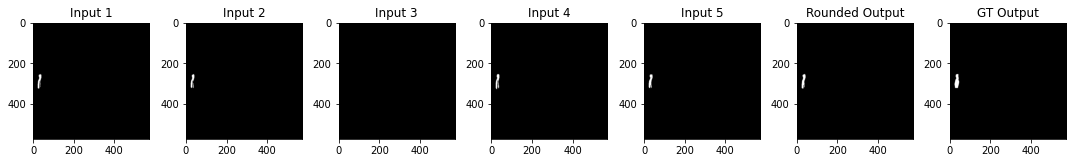

Class Evaluation:  tensor([0.5102])
Max Value:  0.9658243  Min Value:  0.16752547
[1,    46] loss: 0.022260


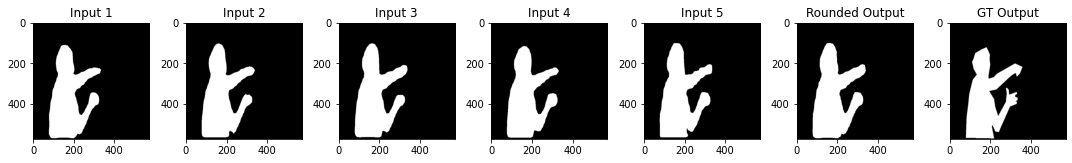

Class Evaluation:  tensor([0.5145])
Max Value:  0.99622214  Min Value:  0.17497167
[1,    48] loss: 0.022501


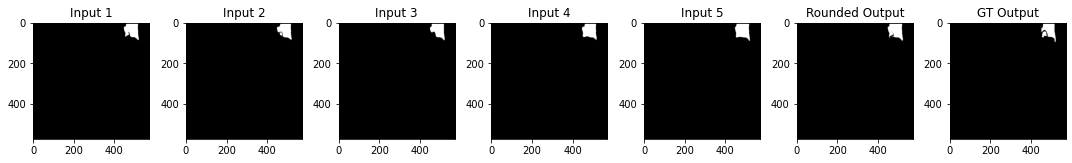

Class Evaluation:  tensor([0.5111])
Max Value:  0.99567986  Min Value:  0.18149558
[1,    50] loss: 0.022283


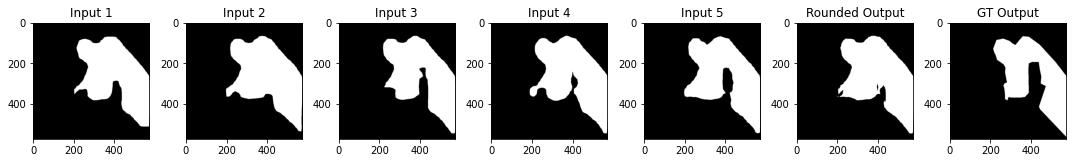

Class Evaluation:  tensor([0.5131])
Max Value:  0.9960735  Min Value:  0.17933315
[1,    52] loss: 0.022306


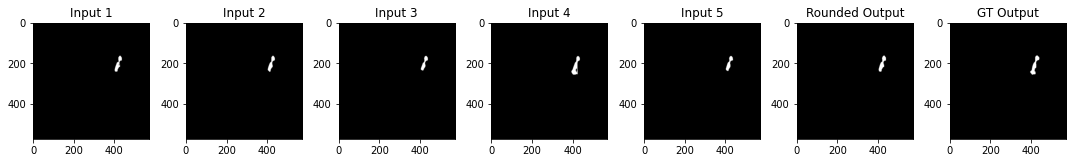

Class Evaluation:  tensor([0.5108])
Max Value:  0.9960717  Min Value:  0.17153716
[1,    54] loss: 0.023149


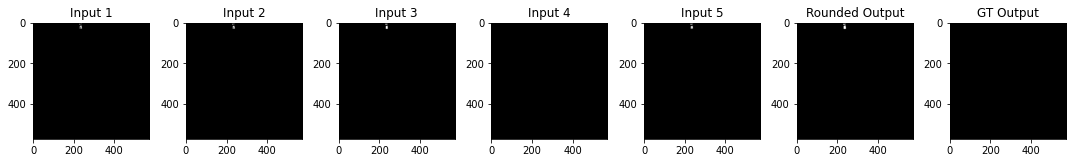

Class Evaluation:  tensor([0.5104])
Max Value:  0.9985794  Min Value:  0.4324597
[1,    56] loss: 0.022591


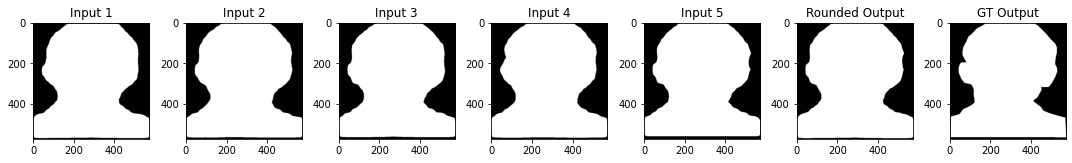

Class Evaluation:  tensor([0.4929])
Max Value:  0.99758065  Min Value:  0.17879383
[1,    58] loss: 0.022111


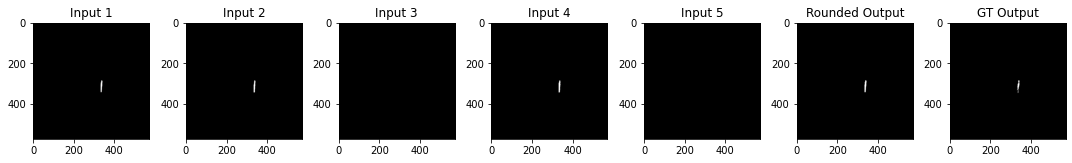

Class Evaluation:  tensor([0.5108])
Max Value:  0.87050307  Min Value:  0.20526727
[1,    60] loss: 0.022296


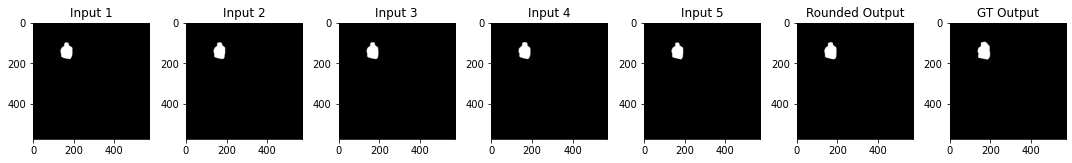

Class Evaluation:  tensor([0.5110])
Max Value:  0.9973882  Min Value:  0.17568497
[1,    62] loss: 0.023014


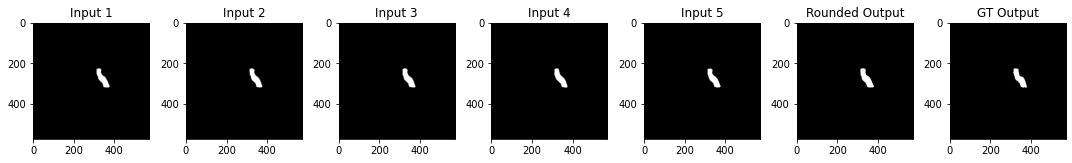

Class Evaluation:  tensor([0.5103])
Max Value:  0.99933225  Min Value:  0.15380378
[1,    64] loss: 0.021837


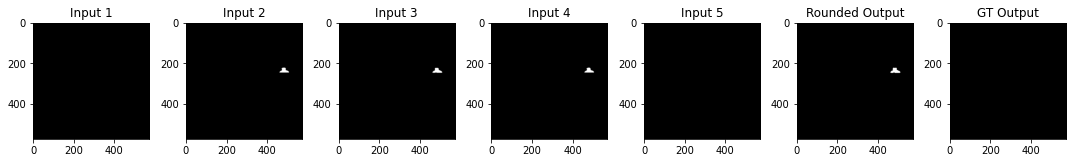

Class Evaluation:  tensor([0.5108])
Max Value:  0.9150032  Min Value:  0.2744502
[1,    66] loss: 0.022362


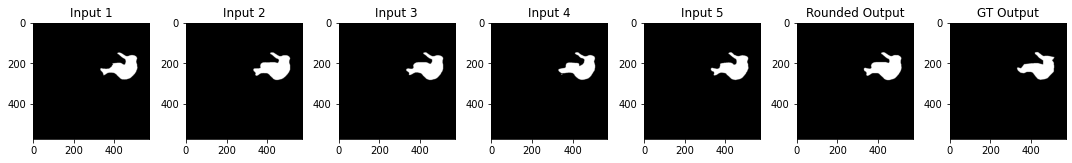

Class Evaluation:  tensor([0.5091])
Max Value:  0.9968696  Min Value:  0.18740666
[1,    68] loss: 0.022386


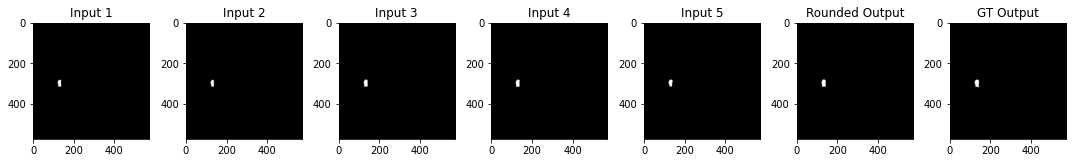

Class Evaluation:  tensor([0.5104])
Max Value:  0.9928478  Min Value:  0.20533575
[1,    70] loss: 0.022609


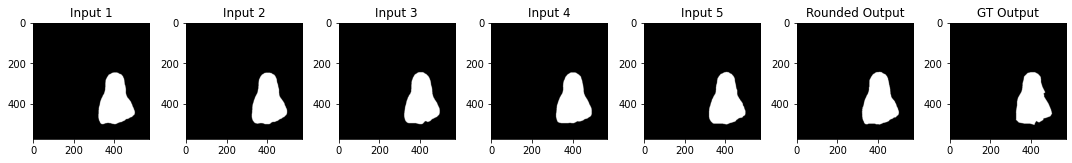

Class Evaluation:  tensor([0.5073])
Max Value:  0.9986155  Min Value:  0.17345752
[1,    72] loss: 0.022927


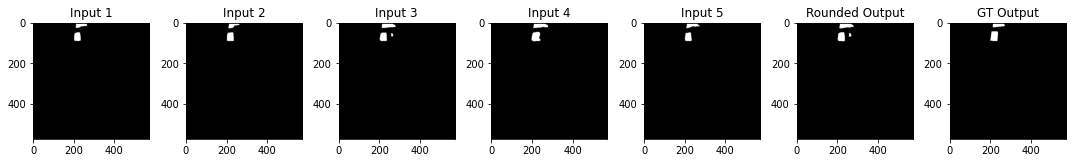

Class Evaluation:  tensor([0.5094])
Max Value:  0.9983224  Min Value:  0.14891101
[1,    74] loss: 0.022642


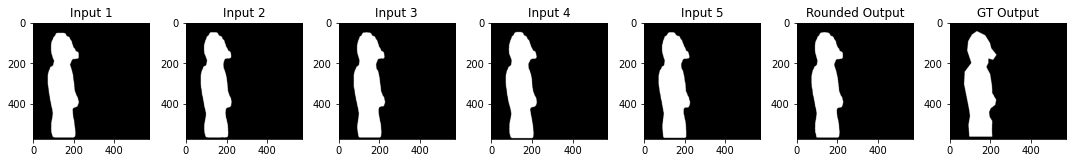

Class Evaluation:  tensor([0.5086])
Max Value:  0.9979761  Min Value:  0.18537685
[1,    76] loss: 0.022384


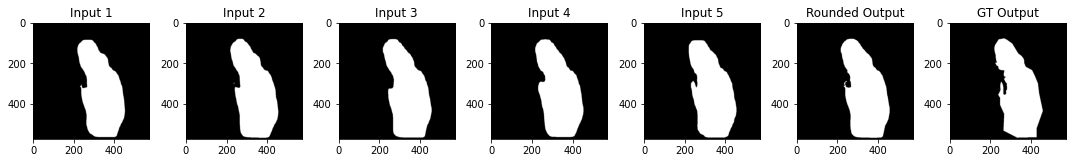

Class Evaluation:  tensor([0.5077])
Max Value:  0.997718  Min Value:  0.18907298
[1,    78] loss: 0.022728


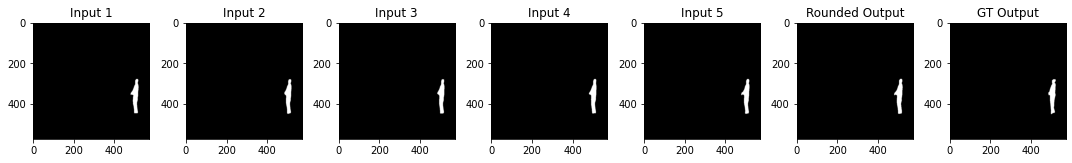

Class Evaluation:  tensor([0.5098])
Max Value:  0.9955844  Min Value:  0.18828249
[1,    80] loss: 0.021576


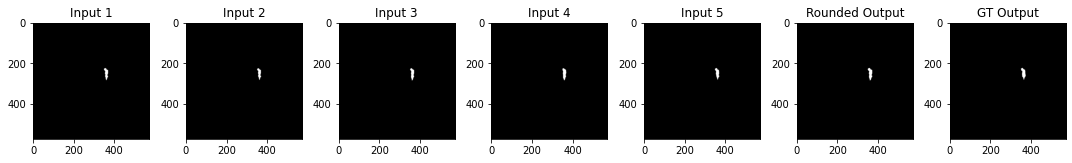

Class Evaluation:  tensor([0.5107])
Max Value:  0.9981218  Min Value:  0.21289094
[1,    82] loss: 0.021413


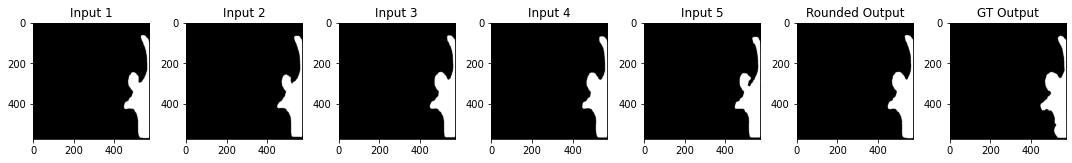

Class Evaluation:  tensor([0.5077])
Max Value:  0.99567515  Min Value:  0.20545104
[1,    84] loss: 0.022215


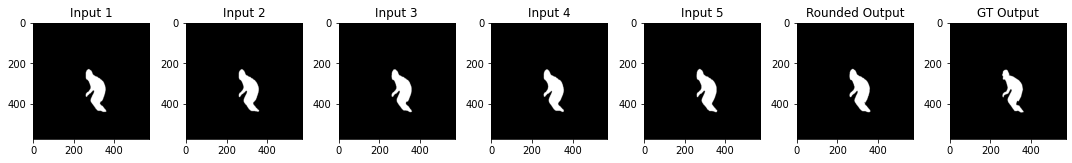

Class Evaluation:  tensor([0.5120])
Max Value:  0.9956032  Min Value:  0.20563261
[1,    86] loss: 0.021302


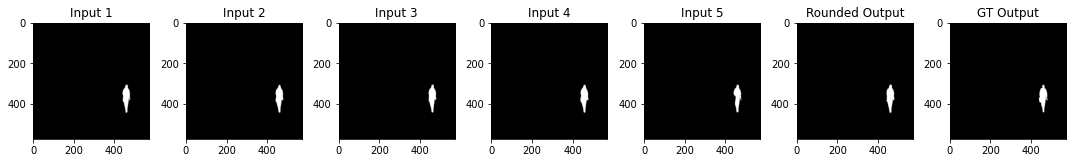

Class Evaluation:  tensor([0.5124])
Max Value:  0.9948086  Min Value:  0.20575592
[1,    88] loss: 0.021824


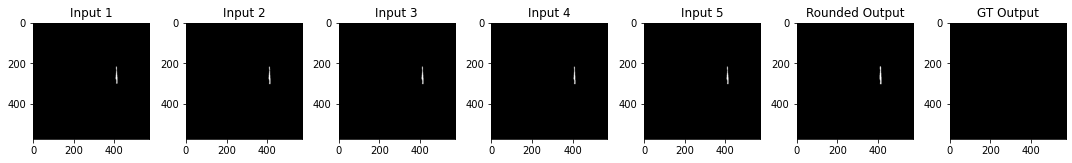

Class Evaluation:  tensor([0.5108])
Max Value:  0.9942061  Min Value:  0.37758052
[1,    90] loss: 0.021699


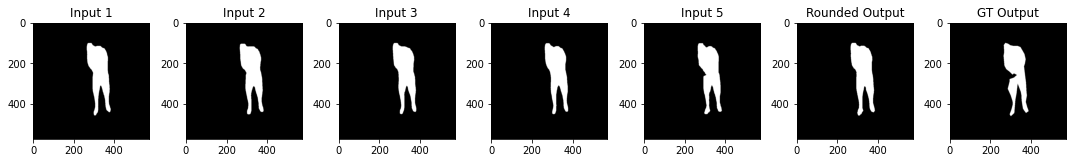

Class Evaluation:  tensor([0.5106])
Max Value:  0.99829525  Min Value:  0.1919582
[1,    92] loss: 0.022092


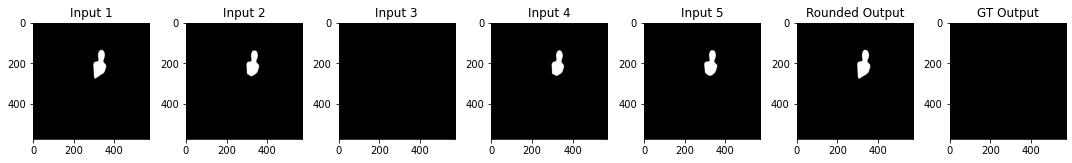

Class Evaluation:  tensor([0.5100])
Max Value:  0.97466  Min Value:  0.19551325
[1,    94] loss: 0.021157


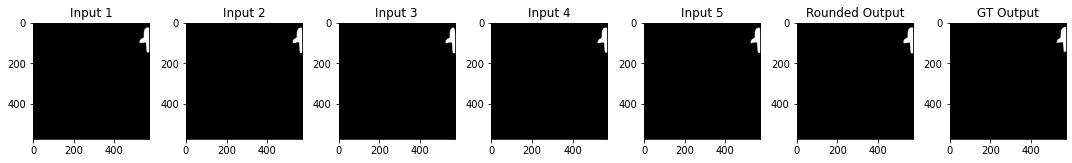

Class Evaluation:  tensor([0.5099])
Max Value:  0.99701107  Min Value:  0.27742627
[1,    96] loss: 0.020079


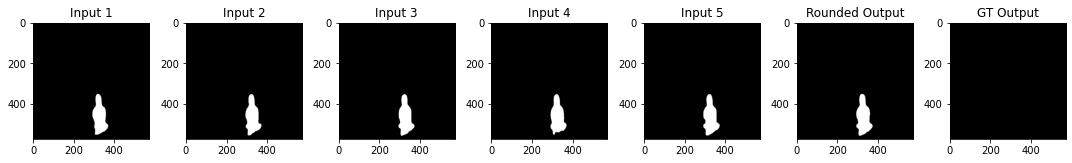

Class Evaluation:  tensor([0.5110])
Max Value:  0.9834742  Min Value:  0.23319837
[1,    98] loss: 0.022654


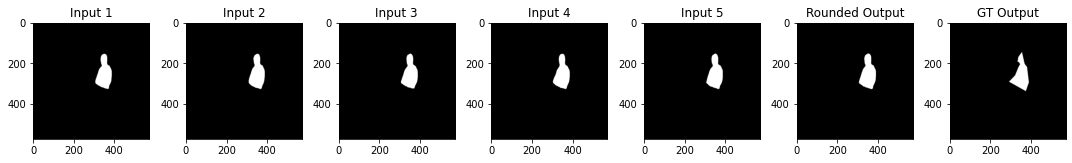

Class Evaluation:  tensor([0.5114])
Max Value:  0.99242413  Min Value:  0.2383318
[1,   100] loss: 0.022352


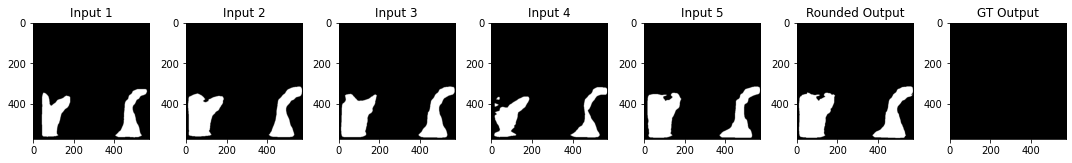

Class Evaluation:  tensor([0.5092])
Max Value:  0.9982502  Min Value:  0.194493
[1,   102] loss: 0.021747


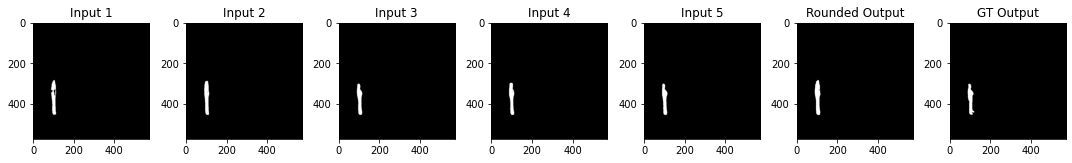

Class Evaluation:  tensor([0.5110])
Max Value:  0.99833053  Min Value:  0.21951814
[1,   104] loss: 0.020562


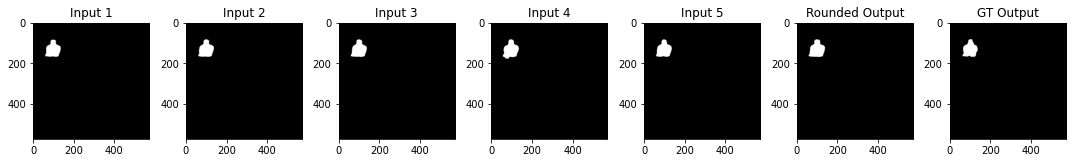

Class Evaluation:  tensor([0.5101])
Max Value:  0.99269885  Min Value:  0.22475287
[1,   106] loss: 0.021141


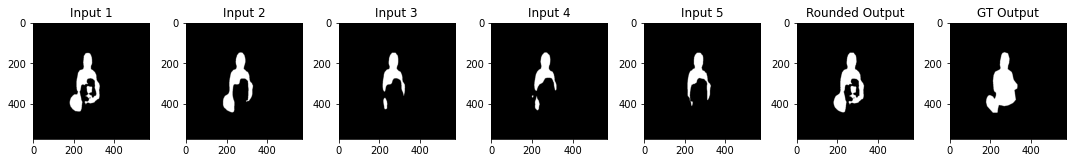

Class Evaluation:  tensor([0.5141])
Max Value:  0.9985367  Min Value:  0.19897072
[1,   108] loss: 0.021068


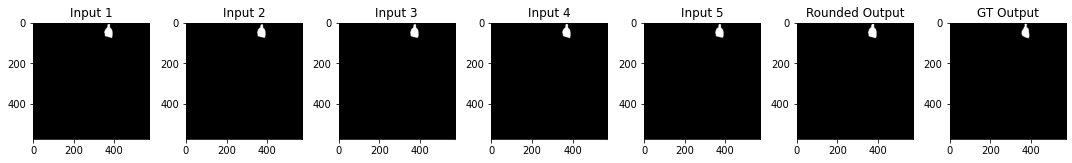

Class Evaluation:  tensor([0.5114])
Max Value:  0.9978986  Min Value:  0.21511224
[1,   110] loss: 0.022279


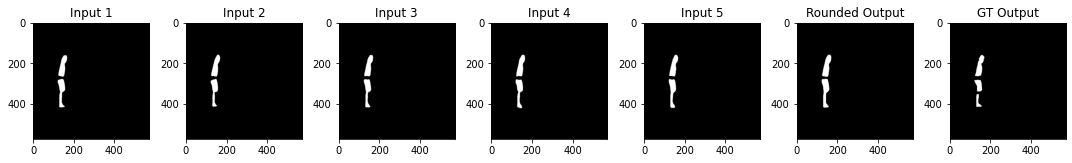

Class Evaluation:  tensor([0.5094])
Max Value:  0.9976661  Min Value:  0.2122691
[1,   112] loss: 0.021212


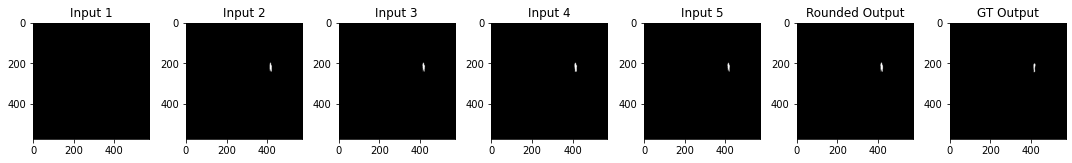

Class Evaluation:  tensor([0.5110])
Max Value:  0.9741219  Min Value:  0.19418217
[1,   114] loss: 0.020735


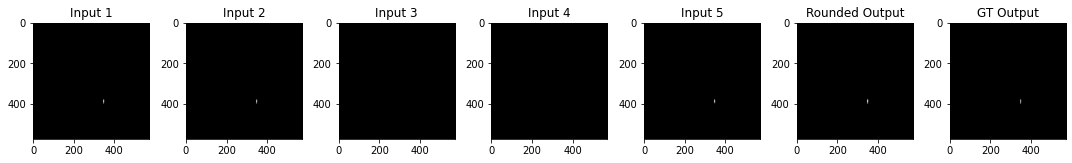

Class Evaluation:  tensor([0.5114])
Max Value:  0.9490666  Min Value:  0.4007746
[1,   116] loss: 0.021469


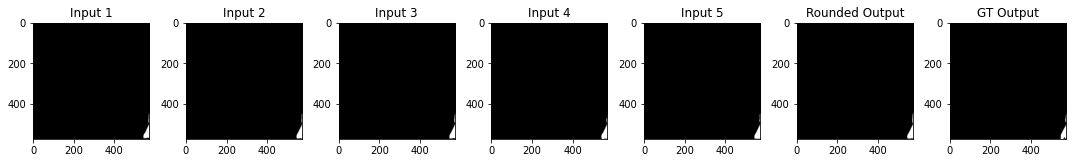

Class Evaluation:  tensor([0.5087])
Max Value:  0.99886143  Min Value:  0.21985237
[1,   118] loss: 0.021877


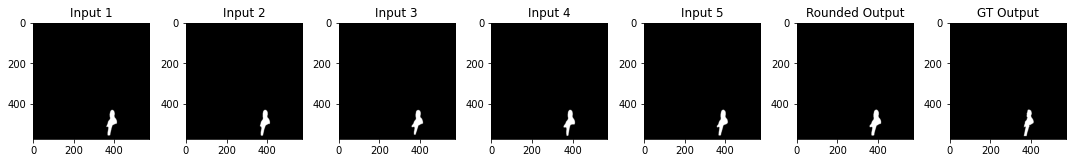

Class Evaluation:  tensor([0.5095])
Max Value:  0.9981108  Min Value:  0.21104479
[1,   120] loss: 0.021722


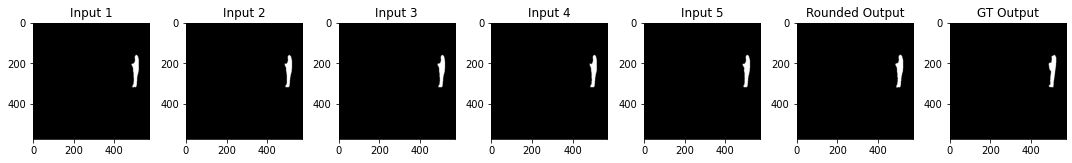

Class Evaluation:  tensor([0.5114])
Max Value:  0.9990852  Min Value:  0.30763146
[1,   122] loss: 0.020437


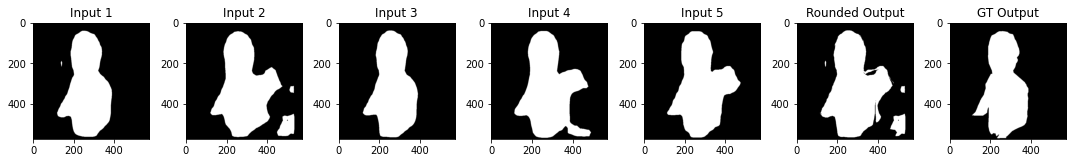

Class Evaluation:  tensor([0.5130])
Max Value:  0.9984627  Min Value:  0.2095394
[1,   124] loss: 0.021613


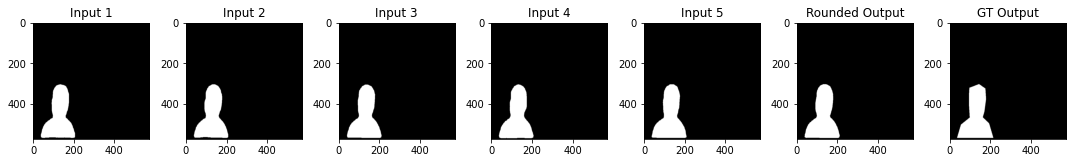

Class Evaluation:  tensor([0.5114])
Max Value:  0.99862695  Min Value:  0.20915566
[1,   126] loss: 0.020857


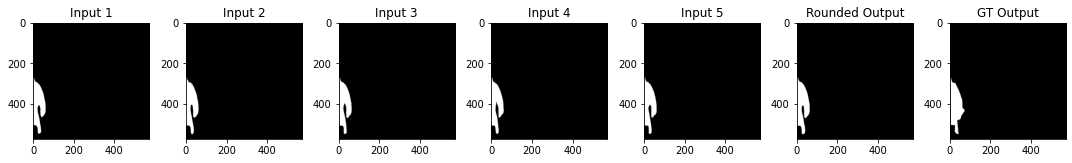

Class Evaluation:  tensor([0.5097])
Max Value:  0.9954367  Min Value:  0.2792875
[1,   128] loss: 0.020430


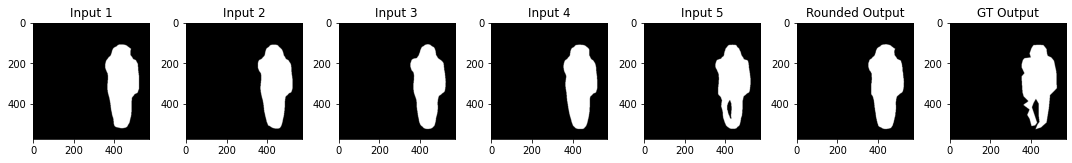

Class Evaluation:  tensor([0.5097])
Max Value:  0.9979215  Min Value:  0.21279097
[1,   130] loss: 0.021234


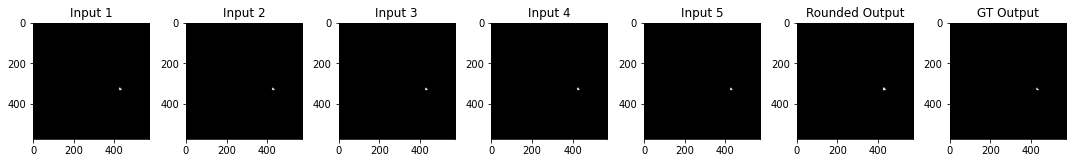

Class Evaluation:  tensor([0.5110])
Max Value:  0.99908555  Min Value:  0.4176677
[1,   132] loss: 0.021043


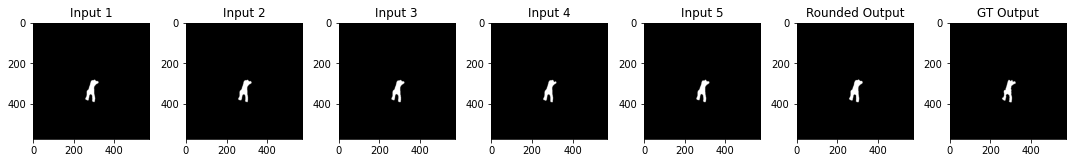

Class Evaluation:  tensor([0.5132])
Max Value:  0.99888104  Min Value:  0.24077111
[1,   134] loss: 0.020541


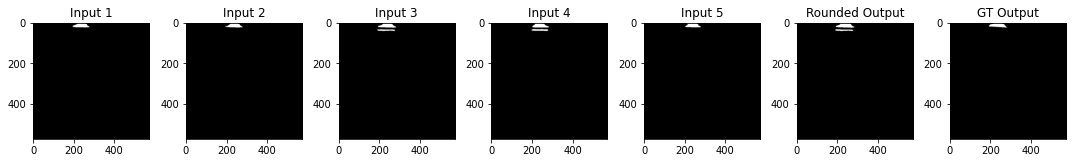

Class Evaluation:  tensor([0.5104])
Max Value:  0.99639696  Min Value:  0.22104734
[1,   136] loss: 0.020284


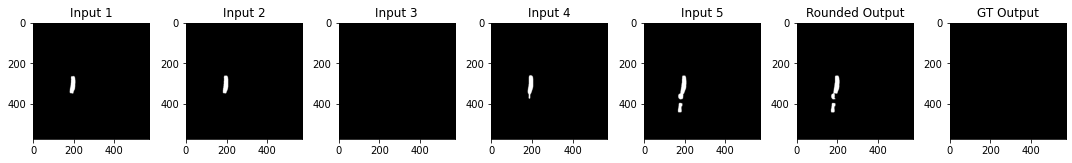

Class Evaluation:  tensor([0.5115])
Max Value:  0.9623198  Min Value:  0.23622745
[1,   138] loss: 0.021261


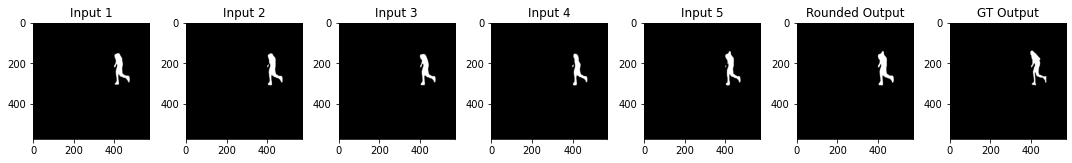

Class Evaluation:  tensor([0.5128])
Max Value:  0.9978734  Min Value:  0.2358209
[1,   140] loss: 0.020711


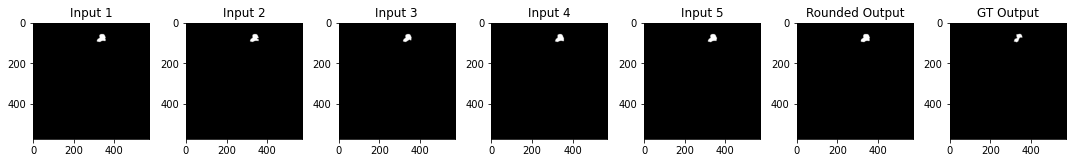

Class Evaluation:  tensor([0.5109])
Max Value:  0.99718493  Min Value:  0.24441385
[1,   142] loss: 0.021093


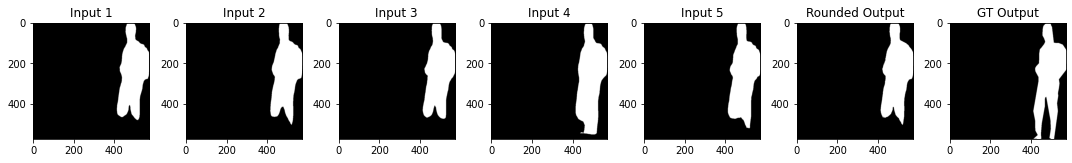

Class Evaluation:  tensor([0.5080])
Max Value:  0.9981735  Min Value:  0.22200543
[1,   144] loss: 0.020813


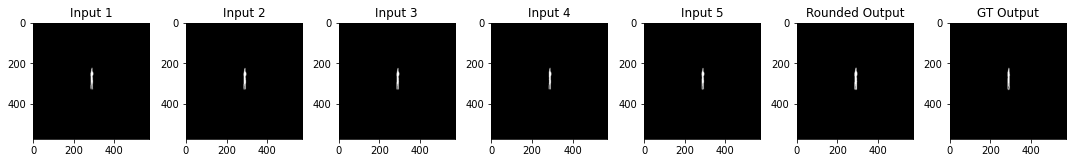

Class Evaluation:  tensor([0.5112])
Max Value:  0.997428  Min Value:  0.35210055
[1,   146] loss: 0.021727


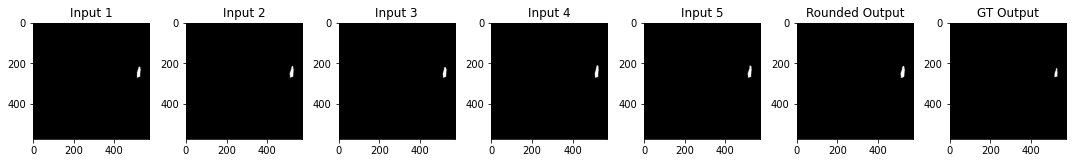

Class Evaluation:  tensor([0.5108])
Max Value:  0.99736243  Min Value:  0.21806554
[1,   148] loss: 0.018395


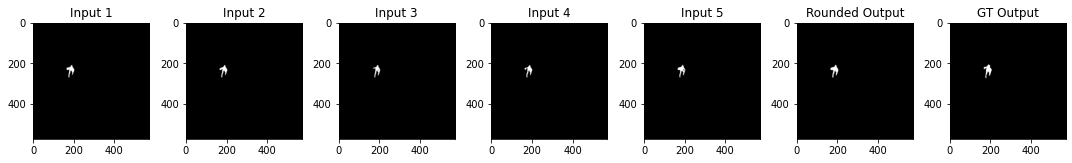

Class Evaluation:  tensor([0.5126])
Max Value:  0.9802991  Min Value:  0.27784836
[2,     2] loss: 0.020754


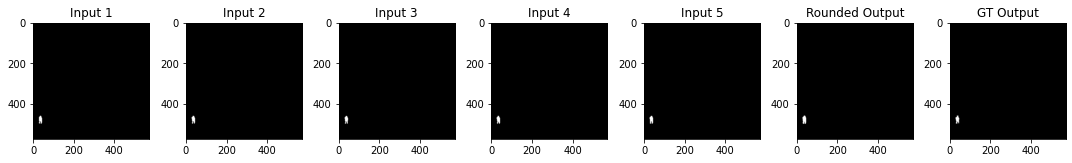

Class Evaluation:  tensor([0.5112])
Max Value:  0.9985461  Min Value:  0.2543607
[2,     4] loss: 0.021599


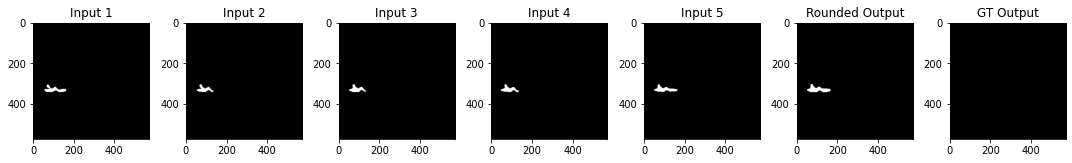

Class Evaluation:  tensor([0.5107])
Max Value:  0.99961215  Min Value:  0.19094978
[2,     6] loss: 0.020762


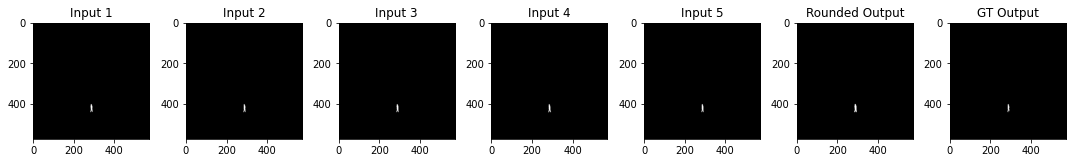

Class Evaluation:  tensor([0.5113])
Max Value:  0.9973482  Min Value:  0.2360275
[2,     8] loss: 0.021867


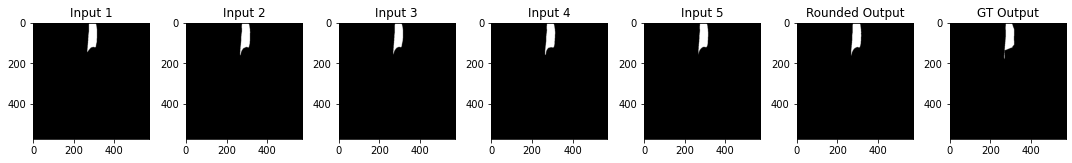

Class Evaluation:  tensor([0.5098])
Max Value:  0.9991393  Min Value:  0.23390476
[2,    10] loss: 0.020312


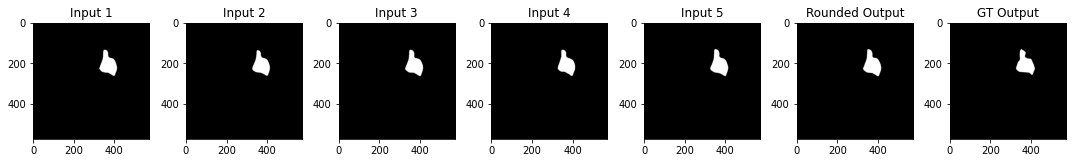

Class Evaluation:  tensor([0.5113])
Max Value:  0.99529016  Min Value:  0.24171285
[2,    12] loss: 0.020044


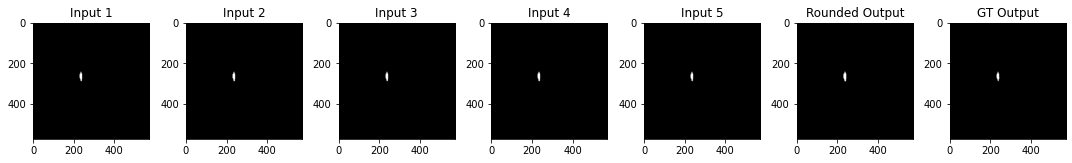

Class Evaluation:  tensor([0.5121])
Max Value:  0.99313956  Min Value:  0.26488507
[2,    14] loss: 0.020887


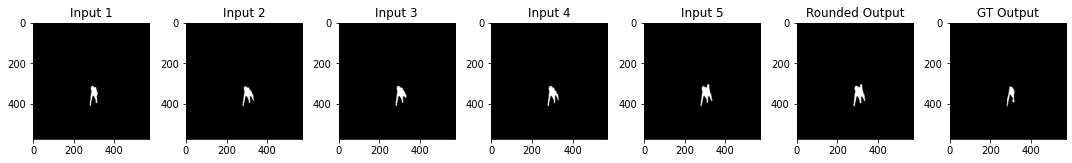

Class Evaluation:  tensor([0.5116])
Max Value:  0.9963129  Min Value:  0.31336346
[2,    16] loss: 0.020790


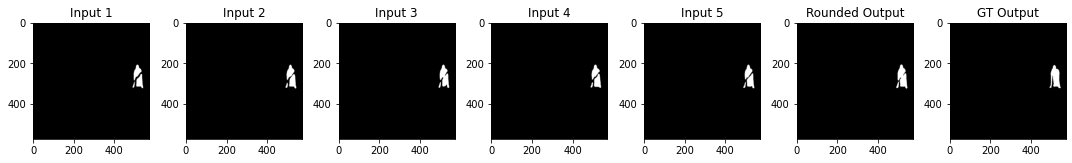

Class Evaluation:  tensor([0.5125])
Max Value:  0.99947447  Min Value:  0.21390496
[2,    18] loss: 0.019695


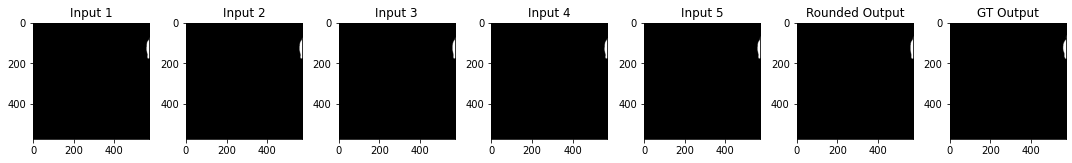

Class Evaluation:  tensor([0.5118])
Max Value:  0.9974663  Min Value:  0.39685485
[2,    20] loss: 0.020590


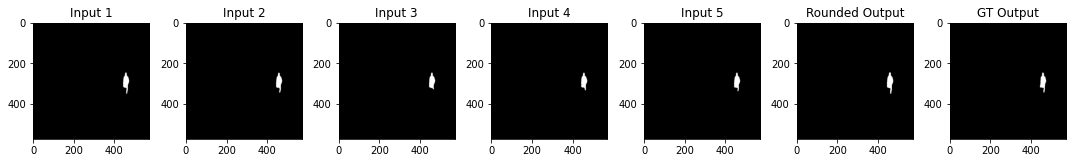

Class Evaluation:  tensor([0.5118])
Max Value:  0.9992957  Min Value:  0.2519444
[2,    22] loss: 0.019866


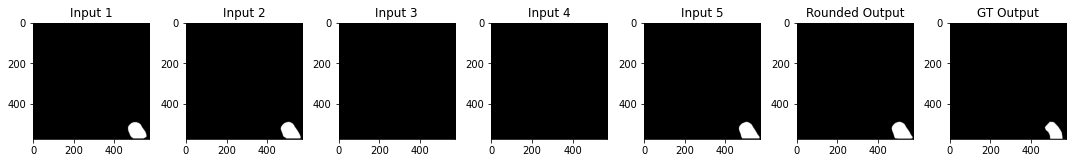

Class Evaluation:  tensor([0.5105])
Max Value:  0.949679  Min Value:  0.3884517
[2,    24] loss: 0.020063


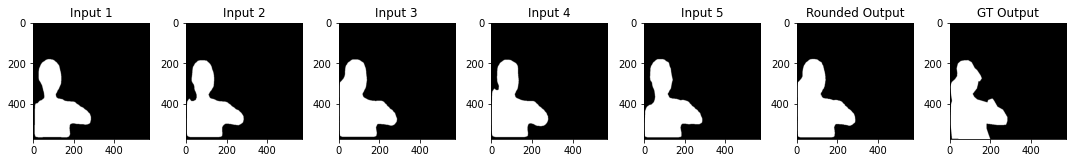

Class Evaluation:  tensor([0.5107])
Max Value:  0.99710196  Min Value:  0.24173637
[2,    26] loss: 0.020592


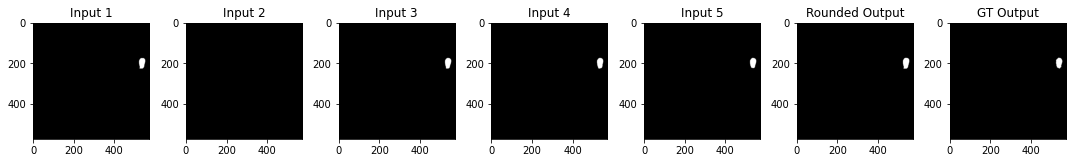

Class Evaluation:  tensor([0.5110])
Max Value:  0.9930409  Min Value:  0.23359363
[2,    28] loss: 0.021149


KeyboardInterrupt: 

In [36]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
OPTIMIZER = "Adam"
ACTIVATION = "sigmoid"
LOSS = "BCELoss"

for layers in [[1],[3],[5]]:
    print("Starting training on network ",layers)
    
    net = SimpleNet(N_CHANNELS,layers,activation=ACTIVATION)
    net = net.to(device).float()
    
    if LOSS == "BCELoss":
        criterion = nn.BCELoss()
        
    criterion_class = nn.NLLLoss()
        
        
    if OPTIMIZER == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif OPTIMIZER == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    checkpoint_path = "work_dirs/simplenet"
    for layer in layers:
        checkpoint_path += "_"+str(layer)
    checkpoint_path += "/" + OPTIMIZER + "_" + ACTIVATION + "_" + LOSS + "/"
    tensorboard_path = checkpoint_path+"tb/"
    os.makedirs(tensorboard_path,exist_ok=True)
    
    train(net,trainloader,(criterion,criterion_class),optimizer, checkpoint_path, tensorboard_path)#, checkpoint="work_dirs/simplenet_1/epoch_25.pt")

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_acc = EventAccumulator('work_dirs/simplenet_1_1_1/sigmoid_BCELoss/tb')
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# E. g. get wall clock, number of steps and value for a scalar 'Accuracy'
w_times, step_nums, vals = zip(*event_acc.Scalars('Loss'))

# Network Summary

In [ ]:
# for i in range(1):
    data = trainset[i]
    
    im_seg = data['im_seg']
    im_res = data['im_res']
    
    res = im_seg[0:3,:,:].numpy().transpose((1,2,0))
    
    fig = plt.figure()
    plt.imshow(res)